# 프로젝트: 작사가 인공지능 만들기

## 데이터:
1Mb 남짓한 노래 가사 텍스트 파일

## 목표:
1. 특수문자 제거, 토크나이저 생성, 패딩 처리의 작업들이 빠짐없이 진행되었는가?
2. 텍스트 제너레이션 결과로 생성된 문장이 해석 가능한 문장인가?
3. 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?

## (1) 라이브러리 및 데이터 불러오기

In [42]:
import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow as tf
import os
import re

print(tf.__version__)

2.6.0


In [43]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' 
txt_list = glob.glob(txt_file_path) 
raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() 
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]']


In [44]:
# 문장 확인
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜀
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜀
    if idx > 15: break   # 문장 15개 미만만 확인
        
print(sentence)

It's not warm when she's away 


## (2) 데이터 전처리

In [45]:
# 입력된 문장 필터링
#     1. 소문자로 바꾸고, 양쪽 공백 지우기
#     2. 특수문자 양쪽에 공백 넣기
#     3. 여러개의 공백은 하나의 공백으로 바꾸기
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾸기
#     5. 다시 양쪽 공백을 지우기
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 필터링 확인
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [46]:
# 정제된 문장 모으기
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과 확인
corpus[:10]

['<start> spoken intro <end>',
 '<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>']

In [47]:
#벡터화(토큰화 + 사전만들기)
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences 사용
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들 것임
    # 우리는 이미 문장을 정제했으니 filters가 필요없음
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀 것임
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    
    tokenizer.fit_on_texts(corpus) # 리스트의 형태로 변환 
    tensor = tokenizer.texts_to_sequences(corpus)  #숫자의 시퀀스 형태로 변환
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=15)  
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춤
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2 2701 2584 ...    0    0    0]
 [   2    7  156 ...    0    0    0]
 [   2   17    7 ...    0    0    0]
 ...
 [   2  311    1 ...    0    0    0]
 [   5   34   45 ... 1161  143    3]
 [   5   34   45 ... 1161  143    3]] <keras_preprocessing.text.Tokenizer object at 0x7f8f9a44e6d0>


In [48]:
print(tensor[:3, :10])

[[   2 2701 2584    3    0    0    0    0    0    0]
 [   2    7  156   62  199    3    0    0    0    0]
 [   2   17    7   34    7 1518   15   76    3    0]]


In [49]:
# 단어 사전 확인
# 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형대로 반환 
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


## (3) 평가 데이터셋 분리

In [50]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2 2701 2584    3    0    0    0    0    0    0    0    0    0    0]
[2701 2584    3    0    0    0    0    0    0    0    0    0    0    0]


In [51]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 선언한 대로tokenizer.num_words의 값은 <pad>를 제외한 7000개
VOCAB_SIZE = tokenizer.num_words + 1   

# 데이터셋 제작 
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [52]:
# test, train 분리
from sklearn.model_selection import train_test_split

# 데이터셋을 입력하고, 테스트 세트의 비율을 설정
enc_train, enc_test, dec_train, dec_test = train_test_split(src_input, tgt_input, test_size=0.2, random_state=42)


## (4) 모델 구성 및 학습

In [12]:
# 모델 구성
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

embedding_size = 256 # 워드 벡터의 차원수 추상적으로 표현되는 크기
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 
# pad 때문에 +1추가

In [13]:
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어 보기
model(src_sample)

<tf.Tensor: shape=(256, 14, 7001), dtype=float32, numpy=
array([[[-8.47537158e-05,  1.09941386e-04,  1.38459545e-05, ...,
          3.59420083e-04, -1.43884317e-04,  3.52643656e-05],
        [-1.02597020e-04,  2.53502978e-04,  1.64390600e-04, ...,
          7.03881815e-05, -4.86015982e-04, -5.12304192e-04],
        [ 6.55732947e-06,  5.08917787e-04,  2.25460215e-04, ...,
         -2.18618061e-05, -6.79485500e-04, -7.55652378e-04],
        ...,
        [ 2.88372859e-03,  3.40811303e-03,  2.03097676e-04, ...,
          9.92263551e-04, -2.61317496e-03, -8.57981911e-04],
        [ 3.29460250e-03,  4.05709073e-03,  2.00920913e-04, ...,
          1.27326394e-03, -2.67134723e-03, -8.88636336e-04],
        [ 3.65048461e-03,  4.67057666e-03,  1.84406599e-04, ...,
          1.54226646e-03, -2.71359133e-03, -8.90710973e-04]],

       [[-8.47537158e-05,  1.09941386e-04,  1.38459545e-05, ...,
          3.59420083e-04, -1.43884317e-04,  3.52643656e-05],
        [-4.49039595e-04,  4.87703015e-04,  1.

In [14]:
# 모델의 구조를 확인
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1792256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 모델 컴파일과 학습
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, # 기본값은 False, True = softmax함수가 적용되지 않음 
    reduction='none'  # 기본값은 SUM. 각자 나오는 값의 반환 원할 때 None을 사용
)
# 모델 컴파일
model.compile(loss=loss, optimizer=optimizer) 

In [16]:
# 모델 학습
history = model.fit(enc_train, dec_train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
879/879 [==============================] - 68s 74ms/step - loss: 3.4895 - val_loss: 3.1429
Epoch 2/10
879/879 [==============================] - 69s 78ms/step - loss: 3.0121 - val_loss: 2.9374
Epoch 3/10
879/879 [==============================] - 70s 80ms/step - loss: 2.8174 - val_loss: 2.8183
Epoch 4/10
879/879 [==============================] - 70s 80ms/step - loss: 2.6609 - val_loss: 2.7323
Epoch 5/10
879/879 [==============================] - 70s 80ms/step - loss: 2.5182 - val_loss: 2.6655
Epoch 6/10
879/879 [==============================] - 70s 80ms/step - loss: 2.3816 - val_loss: 2.6127
Epoch 7/10
879/879 [==============================] - 70s 80ms/step - loss: 2.2501 - val_loss: 2.5737
Epoch 8/10
879/879 [==============================] - 70s 80ms/step - loss: 2.1236 - val_loss: 2.5456
Epoch 9/10
879/879 [==============================] - 70s 80ms/step - loss: 2.0017 - val_loss: 2.5225
Epoch 10/10
879/879 [==============================] - 70s 80ms/step - loss: 1.884

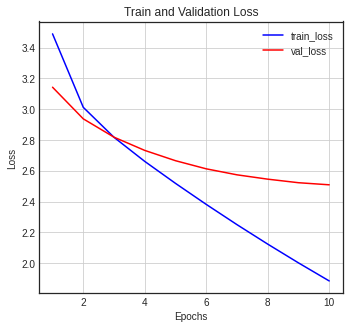

In [17]:
# 모델 학습 히스토리에서 loss, val_loss, mae, val_mae를 차트로 보여줌
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

plt.show()

-> train_loss는 점점 일정하게 줄어드는 반면에 val_loss는 2.5시점에서 더이상 내려가지 않고 train_loss와 차이가 점점 벌어지는 그림을 보인다. 따라서 과대적합이 된 것으로 볼 수 있다. 

## (5) 평가하기

In [18]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15): # 디폴트값 <start>
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [19]:
generate_text(model, tokenizer, init_sentence="<start> I want") 

'<start> i want to get in the zone <end> '

In [20]:
generate_text(model, tokenizer, init_sentence="<start> I like") 

'<start> i like the way how you re kissin me <end> '

In [21]:
generate_text(model, tokenizer, init_sentence="<start> I love") 

'<start> i love you <end> '

In [22]:
generate_text(model, tokenizer, init_sentence="<start> I hope") 

'<start> i hope you can t stay <end> '

In [23]:
generate_text(model, tokenizer, init_sentence="<start> I just") 

'<start> i just wanna be your favorite <end> '

In [24]:
generate_text(model, tokenizer, init_sentence="<start> I hate") 

'<start> i hate to see the <unk> and the <unk> <end> '

In [25]:
generate_text(model, tokenizer, init_sentence="<start> bad") 

'<start> bad bad really , really bad <end> '

In [26]:
generate_text(model, tokenizer, init_sentence="<start> I m sad") 

'<start> i m sad and i m <unk> <end> '

In [27]:
generate_text(model, tokenizer, init_sentence="<start> you look") 

'<start> you look so good <end> '

In [28]:
generate_text(model, tokenizer, init_sentence="<start> we") 

'<start> we ll be bangin on the wall <end> '

-> 전반적으로 가사에 쓰기에 자연스러운 문장들이 잘 만들어졌다. 

## (6) 성능높히기

validation loss를 2.2보다 낮추기 위하여 여러가지 시도를 해볼 것이다. 

## 1. 모델 구성 바꾸기
### (1) 첫 번째 시도

In [29]:
# 모델 구성
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_3 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.rnn_3(out)
        out = self.linear(out)
        
        return out

embedding_size = 256 # 워드 벡터의 차원수 추상적으로 표현되는 크기
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 
# pad 때문에 +1추가

# 모델 컴파일과 학습
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, # 기본값은 False, True = softmax함수가 적용되지 않음 
    reduction='none'  # 기본값은 SUM. 각자 나오는 값의 반환 원할 때 None을 사용
)
# 모델 컴파일
model.compile(loss=loss, optimizer=optimizer) 

# 모델 학습
history = model.fit(enc_train, dec_train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
879/879 [==============================] - 105s 112ms/step - loss: 3.4865 - val_loss: 3.2060
Epoch 2/10
879/879 [==============================] - 98s 111ms/step - loss: 3.0942 - val_loss: 3.0443
Epoch 3/10
879/879 [==============================] - 98s 111ms/step - loss: 2.9518 - val_loss: 2.9590
Epoch 4/10
879/879 [==============================] - 98s 111ms/step - loss: 2.8384 - val_loss: 2.8886
Epoch 5/10
879/879 [==============================] - 98s 111ms/step - loss: 2.7347 - val_loss: 2.8338
Epoch 6/10
879/879 [==============================] - 98s 111ms/step - loss: 2.6386 - val_loss: 2.7835
Epoch 7/10
879/879 [==============================] - 98s 111ms/step - loss: 2.5462 - val_loss: 2.7470
Epoch 8/10
879/879 [==============================] - 98s 111ms/step - loss: 2.4577 - val_loss: 2.7168
Epoch 9/10
879/879 [==============================] - 98s 111ms/step - loss: 2.3718 - val_loss: 2.6933
Epoch 10/10
879/879 [==============================] - 98s 111ms/step - 

-> layer을 추가하니 val_loss 값이 굉장히 천천히 낮아지는 것을 확인 할 수 있다. 

### (2) 두 번째 시도

In [30]:
# 모델 구성
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.batch = tf.keras.layers.BatchNormalization()
        self.drop = tf.keras.layers.Dropout(0.2)
        self.rnn_3 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.rnn_3(out)
        out = self.linear(out)
        
        return out

embedding_size = 256 # 워드 벡터의 차원수 추상적으로 표현되는 크기
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 
# pad 때문에 +1추가

# 모델 컴파일과 학습
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, # 기본값은 False, True = softmax함수가 적용되지 않음 
    reduction='none'  # 기본값은 SUM. 각자 나오는 값의 반환 원할 때 None을 사용
)
# 모델 컴파일
model.compile(loss=loss, optimizer=optimizer) 

# 모델 학습
history = model.fit(enc_train, dec_train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
879/879 [==============================] - 106s 113ms/step - loss: 3.2774 - val_loss: 2.9940
Epoch 2/10
879/879 [==============================] - 99s 112ms/step - loss: 2.8387 - val_loss: 2.7862
Epoch 3/10
879/879 [==============================] - 99s 112ms/step - loss: 2.6094 - val_loss: 2.6566
Epoch 4/10
879/879 [==============================] - 98s 111ms/step - loss: 2.4178 - val_loss: 2.5698
Epoch 5/10
879/879 [==============================] - 99s 112ms/step - loss: 2.2507 - val_loss: 2.5181
Epoch 6/10
879/879 [==============================] - 98s 111ms/step - loss: 2.1017 - val_loss: 2.4718
Epoch 7/10
879/879 [==============================] - 99s 112ms/step - loss: 1.9689 - val_loss: 2.4414
Epoch 8/10
879/879 [==============================] - 98s 112ms/step - loss: 1.8480 - val_loss: 2.4235
Epoch 9/10
879/879 [==============================] - 98s 111ms/step - loss: 1.7410 - val_loss: 2.4138
Epoch 10/10
879/879 [==============================] - 99s 112ms/step - 

-> 앞선 모델 중에 가장 성능이 좋았다. 배치정규화와 드롭아웃 layer을 더 추가하여 시도해보아야겠다.  

### (3) 세 번째 시도

In [31]:
# 모델 구성
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.drop1 = tf.keras.layers.Dropout(0.2)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.drop2 = tf.keras.layers.Dropout(0.2)
        self.rnn_3 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.drop3 = tf.keras.layers.Dropout(0.2)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.batch1(out)
        out = self.drop1(out)
        out = self.rnn_2(out)
        out = self.batch2(out)
        out = self.drop2(out)
        out = self.rnn_3(out)
        out = self.batch3(out)
        out = self.drop3(out)
        out = self.linear(out)
        
        return out

embedding_size = 256 # 워드 벡터의 차원수 추상적으로 표현되는 크기
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 
# pad 때문에 +1추가

# 모델 컴파일과 학습
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, # 기본값은 False, True = softmax함수가 적용되지 않음 
    reduction='none'  # 기본값은 SUM. 각자 나오는 값의 반환 원할 때 None을 사용
)
# 모델 컴파일
model.compile(loss=loss, optimizer=optimizer) 

# 모델 학습
history = model.fit(enc_train, dec_train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
879/879 [==============================] - 109s 116ms/step - loss: 3.1077 - val_loss: 2.8224
Epoch 2/10
879/879 [==============================] - 101s 115ms/step - loss: 2.7049 - val_loss: 2.6438
Epoch 3/10
879/879 [==============================] - 101s 115ms/step - loss: 2.4946 - val_loss: 2.5416
Epoch 4/10
879/879 [==============================] - 101s 115ms/step - loss: 2.3281 - val_loss: 2.4732
Epoch 5/10
879/879 [==============================] - 101s 115ms/step - loss: 2.1862 - val_loss: 2.4315
Epoch 6/10
879/879 [==============================] - 101s 115ms/step - loss: 2.0610 - val_loss: 2.4096
Epoch 7/10
879/879 [==============================] - 101s 115ms/step - loss: 1.9540 - val_loss: 2.3820
Epoch 8/10
879/879 [==============================] - 101s 115ms/step - loss: 1.8606 - val_loss: 2.3732
Epoch 9/10
879/879 [==============================] - 101s 115ms/step - loss: 1.7796 - val_loss: 2.3783
Epoch 10/10
879/879 [==============================] - 101s 115m

-> 이전 모델보다 꾸준하게 val_loss가 잘 내려간다! 에폭 수만 늘리면 더 나아질 것도 같지만 layer, 배치정규화, 드롭아웃을 한번씩 더 추가해서 만들어볼 것이다.

### (4) 네 번재 시도

In [32]:
# 모델 구성
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.drop1 = tf.keras.layers.Dropout(0.2)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.drop2 = tf.keras.layers.Dropout(0.2)
        self.rnn_3 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.drop3 = tf.keras.layers.Dropout(0.2)
        self.rnn_4 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.batch4 = tf.keras.layers.BatchNormalization()
        self.drop4 = tf.keras.layers.Dropout(0.2)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.batch1(out)
        out = self.drop1(out)
        out = self.rnn_2(out)
        out = self.batch2(out)
        out = self.drop2(out)
        out = self.rnn_3(out)
        out = self.batch3(out)
        out = self.drop3(out)
        out = self.rnn_4(out)
        out = self.batch4(out)
        out = self.drop4(out)
        out = self.linear(out)
        
        return out

embedding_size = 256 # 워드 벡터의 차원수 추상적으로 표현되는 크기
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 
# pad 때문에 +1추가

# 모델 컴파일과 학습
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, # 기본값은 False, True = softmax함수가 적용되지 않음 
    reduction='none'  # 기본값은 SUM. 각자 나오는 값의 반환 원할 때 None을 사용
)
# 모델 컴파일
model.compile(loss=loss, optimizer=optimizer) 

# 모델 학습
history = model.fit(enc_train, dec_train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
879/879 [==============================] - 140s 150ms/step - loss: 3.1866 - val_loss: 2.9224
Epoch 2/10
879/879 [==============================] - 130s 148ms/step - loss: 2.8156 - val_loss: 2.7753
Epoch 3/10
879/879 [==============================] - 130s 148ms/step - loss: 2.6398 - val_loss: 2.6474
Epoch 4/10
879/879 [==============================] - 130s 148ms/step - loss: 2.5045 - val_loss: 2.5864
Epoch 5/10
879/879 [==============================] - 130s 148ms/step - loss: 2.3912 - val_loss: 2.5367
Epoch 6/10
879/879 [==============================] - 130s 148ms/step - loss: 2.2920 - val_loss: 2.5056
Epoch 7/10
879/879 [==============================] - 130s 148ms/step - loss: 2.2042 - val_loss: 2.4834
Epoch 8/10
879/879 [==============================] - 130s 148ms/step - loss: 2.1263 - val_loss: 2.4710
Epoch 9/10
879/879 [==============================] - 130s 148ms/step - loss: 2.0551 - val_loss: 2.4581
Epoch 10/10
879/879 [==============================] - 130s 148m

-> 세 번째 시도보다 val_loss가 높게 나왓다. 아무래도 너무 깊은 신경망을 만든 탓인 것 같다. 좀더 간결하게 만들면서 드롭아웃의 비율을 높혀야겠다. 

### (5) 다섯 번째 시도

In [33]:
# 모델 구성
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.drop2 = tf.keras.layers.Dropout(0.3)
        self.rnn_3 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.drop3 = tf.keras.layers.Dropout(0.3)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.batch1(out)
        out = self.drop1(out)
        out = self.rnn_2(out)
        out = self.batch2(out)
        out = self.drop2(out)
        out = self.rnn_3(out)
        out = self.batch3(out)
        out = self.drop3(out)
        out = self.linear(out)
        
        return out

embedding_size = 256 # 워드 벡터의 차원수 추상적으로 표현되는 크기
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 
# pad 때문에 +1추가

# 모델 컴파일과 학습
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, # 기본값은 False, True = softmax함수가 적용되지 않음 
    reduction='none'  # 기본값은 SUM. 각자 나오는 값의 반환 원할 때 None을 사용
)
# 모델 컴파일
model.compile(loss=loss, optimizer=optimizer) 

# 모델 학습
history = model.fit(enc_train, dec_train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
879/879 [==============================] - 109s 116ms/step - loss: 3.1405 - val_loss: 2.8560
Epoch 2/10
879/879 [==============================] - 101s 115ms/step - loss: 2.7675 - val_loss: 2.6905
Epoch 3/10
879/879 [==============================] - 101s 115ms/step - loss: 2.5891 - val_loss: 2.5825
Epoch 4/10
879/879 [==============================] - 101s 115ms/step - loss: 2.4542 - val_loss: 2.5221
Epoch 5/10
879/879 [==============================] - 101s 115ms/step - loss: 2.3436 - val_loss: 2.4740
Epoch 6/10
879/879 [==============================] - 101s 115ms/step - loss: 2.2454 - val_loss: 2.4460
Epoch 7/10
879/879 [==============================] - 101s 115ms/step - loss: 2.1606 - val_loss: 2.4176
Epoch 8/10
879/879 [==============================] - 101s 115ms/step - loss: 2.0850 - val_loss: 2.3952
Epoch 9/10
879/879 [==============================] - 101s 115ms/step - loss: 2.0173 - val_loss: 2.4207
Epoch 10/10
879/879 [==============================] - 101s 115m

-> 역시나 2.38까지 낮추는데에는 성공하였지만 에폭수를 더 늘리거나 다른 모델을 사용하는 방법밖에 안남은 것 같다.

## 2. 다른 모델 사용하기

### (1) GRU

In [38]:
# 모델 구성
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.GRU(hidden_size, return_sequences=True)  
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.rnn_2 = tf.keras.layers.GRU(hidden_size, return_sequences=True)
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.drop2 = tf.keras.layers.Dropout(0.3)
        self.rnn_3 = tf.keras.layers.GRU(hidden_size, return_sequences=True)
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.drop3 = tf.keras.layers.Dropout(0.3)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.batch1(out)
        out = self.drop1(out)
        out = self.rnn_2(out)
        out = self.batch2(out)
        out = self.drop2(out)
        out = self.rnn_3(out)
        out = self.batch3(out)
        out = self.drop3(out)
        out = self.linear(out)
        
        return out

embedding_size = 256 # 워드 벡터의 차원수 추상적으로 표현되는 크기
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 
# pad 때문에 +1추가

# 모델 컴파일과 학습
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, # 기본값은 False, True = softmax함수가 적용되지 않음 
    reduction='none'  # 기본값은 SUM. 각자 나오는 값의 반환 원할 때 None을 사용
)
# 모델 컴파일
model.compile(loss=loss, optimizer=optimizer) 

# 모델 학습
history = model.fit(enc_train, dec_train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
879/879 [==============================] - 90s 95ms/step - loss: 3.1657 - val_loss: 2.9199
Epoch 2/10
879/879 [==============================] - 82s 94ms/step - loss: 2.8489 - val_loss: 2.7758
Epoch 3/10
879/879 [==============================] - 82s 94ms/step - loss: 2.7299 - val_loss: 2.7101
Epoch 4/10
879/879 [==============================] - 82s 94ms/step - loss: 2.6513 - val_loss: 2.6705
Epoch 5/10
879/879 [==============================] - 82s 94ms/step - loss: 2.5922 - val_loss: 2.6408
Epoch 6/10
879/879 [==============================] - 82s 93ms/step - loss: 2.5416 - val_loss: 2.6203
Epoch 7/10
879/879 [==============================] - 82s 93ms/step - loss: 2.5014 - val_loss: 2.6075
Epoch 8/10
879/879 [==============================] - 82s 93ms/step - loss: 2.4640 - val_loss: 2.5922
Epoch 9/10
879/879 [==============================] - 82s 93ms/step - loss: 2.4322 - val_loss: 2.5834
Epoch 10/10
879/879 [==============================] - 82s 93ms/step - loss: 2.403

-> GRU는 데이터가 적은 경우에 더 적합하다. LSTM을 사용한 모델보다 loss와 val_loss 값이 더 높게 나왔다. 이 데이터는 약 7000개로, 데이터가 많아서 GRU보다 LSTM이 더 적합한 것 같다.

### (2) Bidirectional LSTM

In [53]:
# 모델 구성
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn(out)
        out = self.linear(out)
        
        return out

embedding_size = 256 # 워드 벡터의 차원수 추상적으로 표현되는 크기
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 
# pad 때문에 +1추가

# 모델 컴파일과 학습
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, # 기본값은 False, True = softmax함수가 적용되지 않음 
    reduction='none'  # 기본값은 SUM. 각자 나오는 값의 반환 원할 때 None을 사용
)
# 모델 컴파일
model.compile(loss=loss, optimizer=optimizer) 

# 모델 학습
history = model.fit(enc_train, dec_train, batch_size=128, epochs=3, validation_split=0.2)

Epoch 1/3
879/879 [==============================] - 85s 92ms/step - loss: 1.5772 - val_loss: 0.4339
Epoch 2/3
879/879 [==============================] - 80s 91ms/step - loss: 0.2373 - val_loss: 0.1578
Epoch 3/3
879/879 [==============================] - 80s 91ms/step - loss: 0.0653 - val_loss: 0.0898


-> BidirectionalLSTM를 사용하였다. 기존의 단방향인 LSTM과 다르게 양방향으로 정보를 전달하는 양방향 LSTM이다. 지금까지 돌려본 모델 중에서 가장 혁신적이었다.

### (3) Transformer 

In [39]:
from tensorflow.keras import layers

# 트랜스포머 모델 구성
def create_transformer_model(max_sequence_length, num_heads, num_layers, embedding_dim, num_classes):
    # 입력 레이어
    inputs = layers.Input(shape=(max_sequence_length,))
    
    # 입력 임베딩
    embedding = layers.Embedding(input_dim=num_classes, output_dim=embedding_dim)(inputs)
    positional_encoding = layers.Embedding(input_dim=max_sequence_length, output_dim=embedding_dim)(inputs)
    inputs_combined = embedding + positional_encoding
    
    # 인코더 레이어
    encoder_outputs = inputs_combined
    for _ in range(num_layers):
        attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(encoder_outputs, encoder_outputs)
        attention = layers.Dropout(0.1)(attention)
        add = layers.Add()([encoder_outputs, attention])
        normalization = layers.LayerNormalization()(add)
        encoder_outputs = normalization
    
    # 디코더 레이어 (추가적인 구성이 필요한 경우)
    # decoder_outputs = ...
    
    # 출력 레이어
    outputs = layers.Dense(num_classes, activation="softmax")(encoder_outputs)
    
    # 모델 생성
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# 트랜스포머 모델 생성
max_sequence_length = 14
num_heads = 8
num_layers = 4
embedding_dim = 256
num_classes = 10

model = create_transformer_model(max_sequence_length, num_heads, num_layers, embedding_dim, num_classes)

# 모델 컴파일과 학습
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, # 기본값은 False, True = softmax함수가 적용되지 않음 
    reduction='none'  # 기본값은 SUM. 각자 나오는 값의 반환 원할 때 None을 사용
)
# 모델 컴파일
model.compile(loss=loss, optimizer=optimizer) 

# 모델 학습
history = model.fit(enc_train, dec_train, batch_size=128, epochs=10, validation_split=0.2)

NameError: name 'keras' is not defined

-> 적용이 잘못된건지.. loss값이 계산되지 않는다. 이 부분은 더 공부해야할 것 같다. 

### (4) BERT

In [40]:
from transformers import BertTokenizer, TFBertModel

class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.drop2 = tf.keras.layers.Dropout(0.3)
        self.rnn_3 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.drop3 = tf.keras.layers.Dropout(0.3)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.bert_model(out)[0]  # BERT 모델의 출력을 사용
        out = self.rnn_1(out)
        out = self.batch1(out)
        out = self.drop1(out)
        out = self.rnn_2(out)
        out = self.batch2(out)
        out = self.drop2(out)
        out = self.rnn_3(out)
        out = self.batch3(out)
        out = self.drop3(out)
        out = self.linear(out)
        
        return out

embedding_size = 256
hidden_size = 1024

# BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 모델 구성
model = TextGenerator(tokenizer.vocab_size, embedding_size, hidden_size)

# 모델 컴파일
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
model.compile(loss=loss, optimizer=optimizer)
num_words = 7000
# 모델 학습
history = model.fit(enc_train, dec_train, batch_size=128, epochs=10, validation_split=0.2)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10


TypeError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /tmp/ipykernel_830/1279922149.py:21 call  *
        out = self.bert_model(out)[0]  # BERT 모델의 출력을 사용
    /opt/conda/lib/python3.9/site-packages/transformers/models/bert/modeling_tf_bert.py:887 call  *
        outputs = self.bert(
    /opt/conda/lib/python3.9/site-packages/transformers/models/bert/modeling_tf_bert.py:645 call  *
        embedding_output = self.embeddings(
    /opt/conda/lib/python3.9/site-packages/transformers/models/bert/modeling_tf_bert.py:188 call  *
        inputs_embeds = tf.gather(params=self.weight, indices=input_ids)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:5069 gather_v2
        return gather(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/deprecation.py:549 new_func
        return func(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:5056 gather
        return params.sparse_read(indices, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py:713 sparse_read
        value = gen_resource_variable_ops.resource_gather(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_resource_variable_ops.py:566 resource_gather
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:628 _apply_op_helper
        _SatisfiesTypeConstraint(base_type,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:59 _SatisfiesTypeConstraint
        raise TypeError(

    TypeError: Value passed to parameter 'indices' has DataType float32 not in list of allowed values: int32, int64


-> -> BERT를 적용하려면 토큰화 단계부터 적용해야한다. 시간이 부족해서 앞으로 더 공부해서 추가해보도록 해야겠다.

# 자연어 처리 모델 공부하기
## 1. GRU
- GRU의 구조
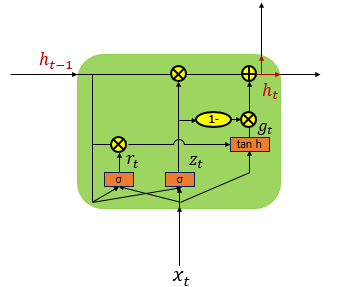

- GRU는 LSTM과 비슷한 이유로 만들어졌는데, LSTM을 구성하는 Time-Step의 Cell을 조금 더 간소화한 버전이다.  
- GRU는 LSTM보다 학습 속도가 빠르다고 알려져있지만, 여러 평가에서 GRU는 LSTM과 비슷한 성능을 보인다.
- 데이터 양이 적을 때는, 매개 변수의 양이 적은 GRU가 조금 더 낫고, 데이터 양이 더 많으면 LSTM이 더 낫다.

## 2. Transformer
- Transformer의 구조
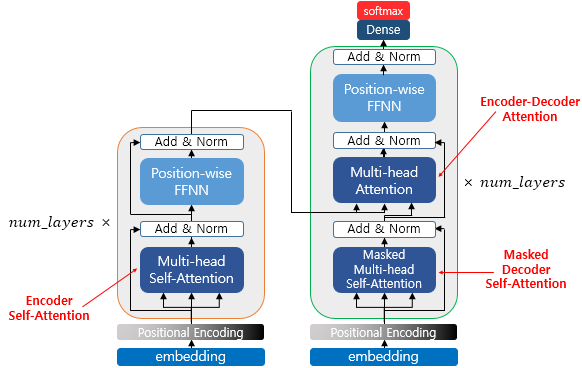

- Transformer은 Attention을 기반으로 만들어진 아키텍쳐이다.  
- 2021년 기준으로 최신 고성능 모델들은 Transformer을 기반으로 구성된다. (GTP, BERT)
- CNN, RNN을 전혀 사용하지 않고 오로지 Attention 기법만을 사용하여 기계 번역부터 모든 자연어 처리가 가능하다.
- 기존 Seq2Seq 모델의 소스 문장의 정보를 압축하여 발생하는 병목현상 문제점을 해결한다. 
- 디코더는 인코더의 모든 출력 중에서 어떤 정보가 중요한지 계산하여 중요한 정보만을 선택해 활용한다.  

## 3. BERT
- BERT의 구조  
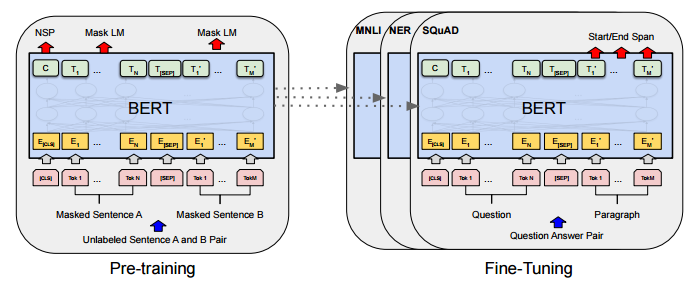

-  "Bidirectional Encoder Representations from Transformers"의 약자  
- 2018년에 개발된 Transformer 기반 자연어 처리 모델  
- 사전 훈련된 언어 모델로서 다양한 자연어 처리 작업에서 매우 좋은 성능을 보인다.  

# 프로젝트 회고

## 배운점
1. strip() 함수는 문자열에서 양쪽 끝에 있는 공백이나 특정 문자를 제거하는 데 사용된다.  
2. tf.keras.preprocessing.text.Tokenizer를 사용하면 쉽게 토큰화 할 수 있다. 
3. loss 종류 중 하나인 SparseCategoricalCrossentropy은 정수로 된 label을 주면 내부적으로 one-hot vector로 변환해서 알아서 loss를 계산해주는 손실함수이다.분류 문제에서 사용된다.  
4. 다른 모델을 사용해보기 위하여 말로만 들었던 GRU, Transformer, BERT, BidirectionalLSTM에 대해 상세하진 않지만 대략적인 개념을 공부하였다.

## 아쉬운점
1. Transformer과 BERT는 기존의 RNN, LSTM과 다르게 성능이 굉장히 좋다고 하여 이 모델을 사용하면 val_loss가 굉장히 낮은 값으로 잘 될 줄 알았는데 아예 기록도 안되어서 어리둥절했다. 아직 개념이해도 다 안된 상태여서 잘 사용을 못했던 것 같다. 더 공부해서 이 프로젝트에 맞춰서 잘 사용해보고 싶다.  
2. 기존의 LSTM에서 에폭 10 안에 val_loss가 2.2 이하로 나오지 않아서 아쉽다. 결국 조원의 정보제공 덕분에 val_loss를 2.2 미만을 넘어서 0.xx까지 낮추었지만 val_loss가 2.5정도였던 기존의 모델보다 문장이 어색했다. 

## 종합평가
자연어 처리는 전처리부터 모델 구성까지 어렵지만 재밌는 과정으로 느껴진다. 모델 학습하는 데에도 시간이 굉장히 오래 걸려서 기다리는 시간이 힘들었다. 이번 기회를 통해 말로만 들었던 GRU, Transformer, BERT에 대해 공부할 수 있어서 유익했다. 아직 컴퓨터 비전 분야보다 더 생소하고 어렵지만 앞으로 더 많이 알고 공부하고 싶다.

# Reference
1. model.fit 가이드  
https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit  
2. Dataset 함수  
https://www.tensorflow.org/api_docs/python/tf/data/Dataset   
3. loss: SparseCategoricalCrossentropy  
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy  
4. SparseCategoricalCrossentropy 설명  
https://jins-sw.tistory.com/16  
5. 자연어 처리 모델 종류 및 주요 특징  
https://thinkingpocket.tistory.com/entry/%EC%9E%90%EC%97%B0%EC%96%B4-%EC%B2%98%EB%A6%AC-%EB%AA%A8%EB%8D%B8%EC%9D%98-%EC%A2%85%EB%A5%98-%EB%B0%8F-%EC%A3%BC%EC%9A%94-%ED%8A%B9%EC%A7%95  
6. 트렌스포머 모델 설명  
https://123okk2.tistory.com/164  
7. 여러 모델들에 대한 설명 담긴 책: 딥러닝을 통한 자연어 처리 입문  
https://wikidocs.net/31379  
8. 버트 논문 리뷰  
https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=winddori2002&logNo=222022178447  
9. RNN, LSTM, GRU 설명  
https://wooono.tistory.com/242  